In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
import pickle

In [ ]:
movies = pd.read_csv('/content/movie.csv')
tags = pd.read_csv('/content/tag.csv')
ratings = pd.read_csv('/content/rating.csv')

In [ ]:
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [ ]:
tags.head()

,userId,movieId,tag,timestamp
0,18,4141,Mark Waters,2009-04-24 18:19:40
1,65,208,dark hero,2013-05-10 01:41:18
2,65,353,dark hero,2013-05-10 01:41:19
3,65,521,noir thriller,2013-05-10 01:39:43
4,65,592,dark hero,2013-05-10 01:41:18


In [ ]:
ratings.head()

,userId,movieId,rating,timestamp
0,1,2.0,3.5,2005-04-02 23:53:47
1,1,29.0,3.5,2005-04-02 23:31:16
2,1,32.0,3.5,2005-04-02 23:33:39
3,1,47.0,3.5,2005-04-02 23:32:07
4,1,50.0,3.5,2005-04-02 23:29:40


In [ ]:
movies['genres'] = movies['genres'].str.replace('|','   ')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will *not* be treated as literal strings when regex=True.
  """Entry point for launching an IPython kernel.


In [ ]:
len(movies.movieId.unique())

27278

In [ ]:
len(ratings.movieId.unique())

8203

In [ ]:
#Performing Content Filtering Firstly 
#limit ratings to user ratings that have rated more that 55 movies --
#Otherwise it becomes impossible to pivot the rating dataframe later for collaborative filtering

ratings_f = ratings.groupby('userId').filter(lambda x: len(x) >= 55)

#list the movie titles that survive the filtering
movie_list_rating = ratings_f.movieId.unique().tolist()

In [ ]:
#no worries: we have kept 100% of the original movie titles in ratings data frame
len(ratings_f.movieId.unique())/len(movies.movieId.unique())*100

29.807903805264313

In [ ]:
#but only 57% of the users
len(ratings_f.userId.unique())/len(ratings.userId.unique())*100

58.68613138686132

In [ ]:
#filter the movies data frame
movies = movies[movies.movieId.isin(movie_list_rating)]

In [ ]:
movies.head(3)

,movieId,title,genres
0,1,Toy Story (1995),Adventure Animation Children Comedy Fa...
1,2,Jumanji (1995),Adventure Children Fantasy
2,3,Grumpier Old Men (1995),Comedy Romance


In [ ]:
#map movie to id
Mapping_file = dict(zip(movies.title.tolist(), movies.movieId.tolist()))

In [ ]:
tags.drop(['timestamp'],1, inplace=True)
ratings_f.drop(['timestamp'],1, inplace=True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:1: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  


In [ ]:
#create a mixed dataframe of movies title, genres
#and all user tags given to each movie
mixed = pd.merge(movies, tags, on='movieId', how='left')
mixed.head(3)

,movieId,title,genres,userId,tag
0,1,Toy Story (1995),Adventure Animation Children Comedy Fa...,1644.0,Watched
1,1,Toy Story (1995),Adventure Animation Children Comedy Fa...,1741.0,computer animation
2,1,Toy Story (1995),Adventure Animation Children Comedy Fa...,1741.0,Disney animated feature


In [ ]:
#create metadata from tags and genres
mixed.fillna(" ", inplace=True)
mixed = pd.DataFrame(mixed.groupby('movieId')['tag'].apply(lambda x: "%s" % '  '.join(x)))
Final = pd.merge(movies, mixed, on= 'movieId', how='left')
Final['metadata']= Final[['tag','genres']].apply(lambda x: ' '.join(x), axis = 1)
Final[['movieId','title','metadata']].head(3)

,movieId,title,metadata
0,1,Toy Story (1995),Watched computer animation Disney animated f...
1,2,Jumanji (1995),time travel adapted from:book board game ch...
2,3,Grumpier Old Men (1995),old people that is actually funny sequel feve...


In [ ]:
Final.shape

(8131, 5)

In [ ]:
Final.loc[1,"metadata"]

'time travel  adapted from:book  board game  childhood recaptured  game  herds of CGI animals  scary  see also:Zathura  time  time travel  board game  fantasy  Robin Williams  scary  time travel  Robin Williams  Joe Johnston  Robin Williams  kid flick  jungle  Robin Williams Adventure   Children   Fantasy'

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer 
tfidf = TfidfVectorizer(stop_words='english')
tfidf_matrix = tfidf.fit_transform(Final['metadata'])
tfidf_df = pd.DataFrame(tfidf_matrix.toarray(), index=Final.index.tolist())
print(tfidf_df.shape)

(8131, 9438)


In [ ]:
tfidf_df.shape

(8131, 9438)

In [ ]:
tfidf_df.loc[0]

0       0.0
1       0.0
2       0.0
3       0.0
4       0.0
       ... 
9433    0.0
9434    0.0
9435    0.0
9436    0.0
9437    0.0
Name: 0, Length: 9438, dtype: float64

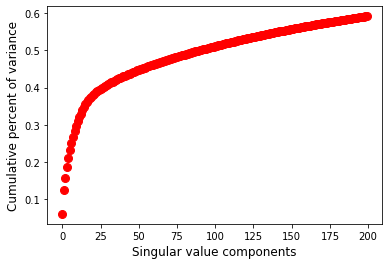

In [ ]:
#Compress with svd
from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components=200)
latent_matrix = svd.fit_transform(tfidf_df)
#plot var explained to see what latent dimensions to use
explained = svd.explained_variance_ratio_.cumsum()
plt.plot(explained, '. ' , ms=16, color ='red')
plt.xlabel('Singular value components', fontsize = 12)
plt.ylabel('Cumulative percent of variance', fontsize=12)
plt.show()

In [ ]:
#number of latent dimensions to keep
n = 200
latent_matrix_1_df = pd.DataFrame(latent_matrix[:,0:n], index= Final.title.tolist())

In [ ]:
#the content latent matrix
latent_matrix.shape

(8131, 200)

In [ ]:
ratings_f.head()

,userId,movieId,rating
0,1,2.0,3.5
1,1,29.0,3.5
2,1,32.0,3.5
3,1,47.0,3.5
4,1,50.0,3.5


In [ ]:
ratings_f1 = pd.merge(movies[['movieId']], ratings_f, on="movieId", how="right")

In [ ]:
ratings_f2 = ratings_f1.pivot(index ='movieId',columns='userId', values='rating').fillna(0)

In [ ]:
ratings_f2.head(3)

userId,1,2,3,5,7,8,11,13,14,16,...,666,667,670,671,672,673,675,678,680,682
movieId,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,4.0,0.0,0.0,4.0,4.5,4.0,4.5,3.0,...,5.0,4.5,0.0,0.0,0.0,3.0,0.0,4.0,0.0,0.0
2,3.5,0.0,0.0,3.0,0.0,0.0,0.0,3.0,0.0,0.0,...,0.0,0.0,2.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0
3,0.0,4.0,0.0,0.0,3.0,5.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,3.0,3.0,0.0,0.0


In [ ]:
ratings_f2.shape

(8131, 402)

In [ ]:
len(ratings_f.movieId.unique())

8131

In [ ]:
from sklearn.decomposition import TruncatedSVD 
svd = TruncatedSVD(n_components=100)
latent_matrix_2 = svd.fit_transform(ratings_f2)
latent_matrix_2_df = pd.DataFrame(
    latent_matrix_2,
    index = Final.title.tolist()
)

In [ ]:
latent_matrix_2_df.shape

(8131, 100)

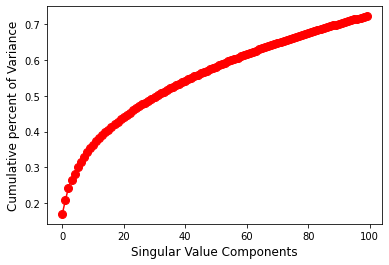

In [ ]:
#ploting variance to see what latent dimensions to use
explained = svd.explained_variance_ratio_.cumsum()
plt.plot(explained,'.-', ms =16, color = 'red')
plt.xlabel('Singular Value Components', fontsize = '12')
plt.ylabel('Cumulative percent of Variance', fontsize = '12')
plt.show()

In [ ]:
latent_matrix_1_df.head()

,0,1,2,3,4,5,6,7,8,9,...,190,191,192,193,194,195,196,197,198,199
Toy Story (1995),0.041050,0.041150,0.054369,-0.009130,-0.089828,0.118624,0.000737,0.151001,-0.004319,0.013135,...,-0.010842,0.058209,0.040463,0.035319,-0.066681,-0.005003,-0.022971,-0.009502,-0.001110,-0.032273
Jumanji (1995),0.013062,0.006838,0.026607,0.003654,-0.036423,0.079146,0.002407,0.095353,0.013036,-0.003213,...,0.007924,-0.008303,-0.010371,-0.013068,-0.001158,-0.010983,0.013737,-0.004489,0.012944,0.016958
Grumpier Old Men (1995),0.078317,0.074793,-0.018658,0.080672,-0.001118,-0.000692,0.000390,-0.002757,0.000690,-0.000859,...,-0.032980,0.018037,0.010720,0.006536,0.034674,0.019116,-0.012974,0.012513,0.070548,-0.022590
Waiting to Exhale (1995),0.314982,0.074781,-0.077730,0.171099,0.006870,-0.003395,-0.002149,-0.010885,-0.005729,0.000153,...,-0.019119,-0.015258,0.001383,0.012875,0.015100,-0.006963,-0.007431,-0.002324,-0.018317,-0.002809
Father of the Bride Part II (1995),0.061835,0.077155,0.010895,-0.020280,-0.008645,0.028561,-0.000014,0.040207,0.002462,0.001617,...,-0.037504,0.016262,0.013927,-0.028863,0.014106,0.029355,0.029172,-0.034768,0.032662,-0.020921


In [ ]:
latent_matrix_2_df.head()

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
Toy Story (1995),37.286711,1.130353,7.813153,7.283178,1.225788,-9.547843,-2.118128,6.822861,1.571794,-2.166929,...,3.384971,-1.893252,2.798595,2.826195,1.393849,-1.889109,0.591977,3.888113,1.681899,-0.297777
Jumanji (1995),17.054617,-3.642274,9.775001,3.600478,-3.056880,-4.362304,-0.107459,1.162258,0.384973,-2.954159,...,2.042306,2.208172,-0.033431,-1.020098,-1.001747,-1.509912,1.860929,-1.160642,-2.093251,-0.038698
Grumpier Old Men (1995),8.546980,-3.549305,6.274204,1.624148,-4.929750,-1.176991,-1.106682,0.973107,-0.486193,-0.641476,...,-0.222778,-0.479762,1.799790,-0.889714,-0.288910,-1.299777,-0.056911,0.100996,-0.845881,0.306332
Waiting to Exhale (1995),1.853337,-2.945653,1.418675,1.573048,-3.189835,-0.194032,2.115834,0.446208,0.936793,-0.088054,...,-0.354222,0.312655,0.930182,-0.654046,0.721816,0.510867,-0.421306,-0.417963,0.449513,-0.907089
Father of the Bride Part II (1995),7.827668,-4.997024,7.442765,2.798895,-5.273457,-0.653519,-1.899777,0.327469,0.430462,-1.540197,...,-0.531126,1.810466,1.128893,-0.566084,-1.270193,0.537511,-2.386141,-0.308447,-1.175427,-0.004167


In [ ]:
#Running content & collaborative and hybrid cosine similarity 
from sklearn.metrics.pairwise import cosine_similarity
#take the latent vectors for a selected movie from both content and collaborative matrices
a_1 = np.array(latent_matrix_1_df.loc[ 'Toy Story (1995)' ]).reshape(1, -1)
a_2 = np.array(latent_matrix_2_df.loc[ 'Toy Story (1995)' ]).reshape(1, -1)

#calculating the similarity of this movie with the other movies in th list 
score_1 = cosine_similarity(latent_matrix_1_df, a_1).reshape(-1)
score_2 = cosine_similarity(latent_matrix_2_df, a_2).reshape(-1)

#an average measure of both content and collaborative 
hybrid = ((score_1 + score_2)/2.0)

#forming a data frame of similar movies
dictDf = {'content' : score_1, 'collaborative' : score_2, 'hybrid' : hybrid}
similar = pd.DataFrame(dictDf, index = latent_matrix_1_df.index)

#sorting it on the basis of either : content, collaborative or hybrid
similar.sort_values('hybrid', ascending=False, inplace=True) 

similar[1:].head(11)

,content,collaborative,hybrid
Toy Story 2 (1999),0.951061,0.771074,0.861068
"Bug's Life, A (1998)",0.869146,0.659408,0.764277
Finding Nemo (2003),0.839199,0.642416,0.740808
"Monsters, Inc. (2001)",0.831810,0.635673,0.733741
"Incredibles, The (2004)",0.802204,0.563004,0.682604
Antz (1998),0.861838,0.503136,0.682487
Ice Age (2002),0.805370,0.459839,0.632605
Toy Story 3 (2010),0.784657,0.464652,0.624654
Up (2009),0.766592,0.402587,0.584589
Ratatouille (2007),0.801245,0.366176,0.583711
